<a href="https://colab.research.google.com/github/nurikahraman/FoodTracker/blob/main/Fisheye_Effect_Correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Kod**

Yukarıda belirtildiği gibi, kamera kalibrasyonu için en az 10 test modeline ihtiyacımız var. OpenCV, bir satranç tahtasının bazı resimleriyle birlikte gelir (bkz. örnekler/veriler/left01.jpg – left14.jpg), bu yüzden bunları kullanacağız. Bir satranç tahtası görüntüsü düşünün. Kameranın kalibrasyonu için gereken önemli girdi verileri, 3D gerçek dünya noktaları seti ve bu noktaların görüntüdeki karşılık gelen 2D koordinatlarıdır. Görüntüden kolayca bulabileceğimiz 2D görüntü noktaları tamam. (Bu görüntü noktaları, satranç tahtalarında iki siyah karenin birbirine değdiği yerlerdir)

Peki ya gerçek dünya uzayından gelen 3B noktalar? Bu görüntüler statik bir kameradan alınır ve satranç tahtaları farklı konumlara ve yönlere yerleştirilir. Bu yüzden bilmemiz gerekiyor
 Değer. Ancak basitlik için satranç tahtasının XY düzleminde sabit tutulduğunu (yani her zaman Z=0) ve kameranın buna göre hareket ettirildiğini söyleyebiliriz. Bu husus sadece X,Y değerlerini bulmamıza yardımcı olur. Şimdi X,Y değerleri için noktaları basitçe (0,0), (1,0), (2,0), ... noktaların yerini gösterir. Bu durumda elde edeceğimiz sonuçlar satranç tahtası karesinin büyüklüğü ölçeğinde olacaktır. Ancak kare boyutunu biliyorsak (diyelim ki 30 mm), değerleri (0,0), (30,0), (60,0), ... olarak geçebiliriz. Böylece sonuçları mm cinsinden elde ediyoruz (Bu durumda o görüntüleri çekmediğimiz için kare boyutu bilmiyoruz, bu yüzden kare boyutu olarak geçiyoruz).

**Kurulum**

Yani satranç tahtasında desen bulmak için **cv.findChessboardCorners()** fonksiyonunu kullanabiliriz. Ayrıca 8x8 ızgara, 5x5 ızgara vb. gibi ne tür bir desen aradığımızı da geçmemiz gerekiyor. Bu örnekte 7x6 ızgara kullanıyoruz. (Normalde bir satranç tahtasının 8x8 kareleri ve 7x7 iç köşeleri vardır). Desen elde edilirse True olacak köşe noktalarını ve retval'i döndürür. Bu köşeler sırayla yerleştirilecektir (soldan sağa, yukarıdan aşağıya)

**Not**
    *   Bu işlev, tüm görüntülerde gerekli deseni bulamayabilir. Bu nedenle, iyi bir seçenek, kodu kamerayı başlatacak ve gerekli desen için her kareyi kontrol edecek şekilde yazmaktır. Desen elde edildikten sonra köşeleri bulun ve bir listede saklayın. Ayrıca, satranç tahtamızı farklı yönlerde ayarlayabilmemiz için bir sonraki kareyi okumadan önce biraz aralık verin. Gerekli sayıda iyi desen elde edilene kadar bu işleme devam edin. Burada verilen örnekte bile, verilen 14 resimden kaçının iyi olduğundan emin değiliz. Bu nedenle, tüm görüntüleri okumalı ve sadece iyi olanları almalıyız.
    *   Satranç tahtası yerine alternatif olarak dairesel bir ızgara kullanabiliriz. Bu durumda, deseni bulmak için cv.findCirclesGrid() fonksiyonunu kullanmalıyız. Dairesel bir ızgara kullanarak kamera kalibrasyonu yapmak için daha az görüntü yeterlidir.


Köşeleri bulduktan sonra, **cv.cornerSubPix()** kullanarak doğruluklarını artırabiliriz. Deseni **cv.drawChessboardCorners()** kullanarak da çizebiliriz. Tüm bu adımlar aşağıdaki koda dahil edilmiştir:

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import glob
import cv2
from google.colab.patches import cv2_imshow

/content/drive/MyDrive/Colab Notebooks/Photo Tools/Fisheye Effect Correction/calib_radial.jpg


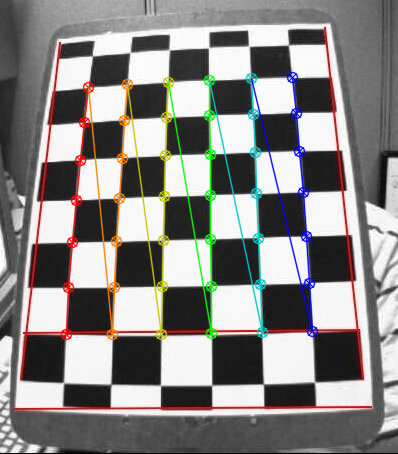

/content/drive/MyDrive/Colab Notebooks/Photo Tools/Fisheye Effect Correction/Perspective.jpg


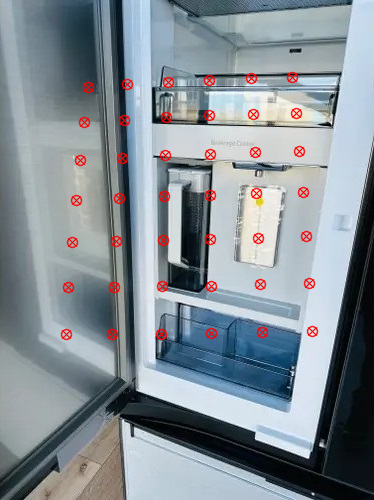

In [13]:

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('/content/drive/MyDrive/Colab Notebooks/Photo Tools/Fisheye Effect Correction/*.jpg')



for fname in images:
 print(fname)
 img = cv2.imread(fname, cv2.IMREAD_UNCHANGED)
 gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

 # Find the chess board corners
 ret, corners = cv2.findChessboardCorners(gray, (7,6), None)

 # If found, add object points, image points (after refining them)
 if ret == True:
   objpoints.append(objp)

   corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
   imgpoints.append(corners2)

 # Draw and display the corners
 cv2.drawChessboardCorners(img, (7,6), corners2, ret)
 cv2_imshow(img)
 #cv2.waitKey(500)

#cv2.destroyAllWindows()

Üzerine desen çizilmiş bir resim aşağıda gösterilmiştir:

**Calibration**

Artık nesne noktalarımıza ve görüntü noktalarımıza sahip olduğumuza göre, kalibrasyona gitmeye hazırız. Kamera matrisini, bozulma katsayılarını, döndürme ve öteleme vektörlerini vb. döndüren cv.calibrateCamera() fonksiyonunu kullanabiliriz.

In [14]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

**Undistortion**

Şimdi, bir görüntü alabilir ve onu bozabiliriz. OpenCV bunu yapmak için iki yöntemle birlikte gelir. Ancak önce, cv.getOptimalNewCameraMatrix() kullanarak ücretsiz bir ölçeklendirme parametresine dayalı olarak kamera matrisini iyileştirebiliriz. Ölçekleme parametresi alpha=0 ise, minimum istenmeyen piksele sahip bozulmamış görüntü döndürür. Bu nedenle, görüntü köşelerindeki bazı pikselleri bile kaldırabilir. alpha=1 ise, bazı ekstra siyah görüntülerle tüm pikseller korunur. Bu işlev aynı zamanda sonucu kırpmak için kullanılabilecek bir görüntü ROI'si döndürür.

Yani, bu durumda yeni bir görüntü (left12.jpg alıyoruz. Bu, bu bölümdeki ilk resimdir)

In [15]:
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Photo Tools/Fisheye Effect Correction/calib_radial.jpg')
h, w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

1. Using **cv2.undistort()**

Bu en kolay yoldur. Sadece işlevi çağırın ve sonucu kırpmak için yukarıda elde edilen ROI'yi kullanın.

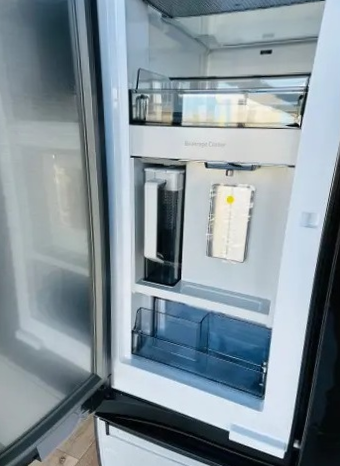

In [16]:
# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('calibresult1.png', dst)
cv2_imshow(dst)

2. Using **remapping**

Bu yol biraz daha zor. İlk olarak, bozuk görüntüden bozulmamış görüntüye bir eşleme işlevi bulun. Ardından yeniden eşleme işlevini kullanın.

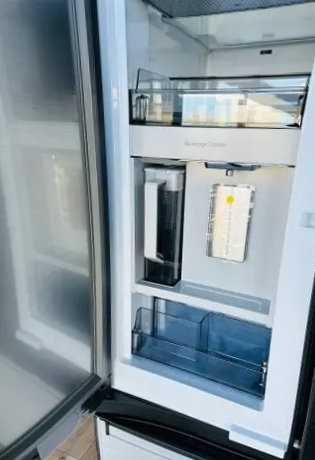

In [17]:
# undistort
mapx, mapy = cv2.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)

# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('calibresult2.png', dst)
cv2_imshow(dst)

Yine de, her iki yöntem de aynı sonucu verir.
Sonuçta tüm kenarların düz olduğunu görebilirsiniz.

Artık ileride kullanmak üzere NumPy'deki yazma işlevlerini (np.savez, np.savetxt vb.) kullanarak kamera matrisini ve bozulma katsayılarını saklayabilirsiniz.